# CODE 12: Listing 7.1 Elemental Matrices - Pag 175
# CODE 13: Listing 7.2 Force vector - Pag 176
# CODE 14: Listing 7.3 Extrapolation Scheme - Pag 177

<IPython.core.display.Javascript object>


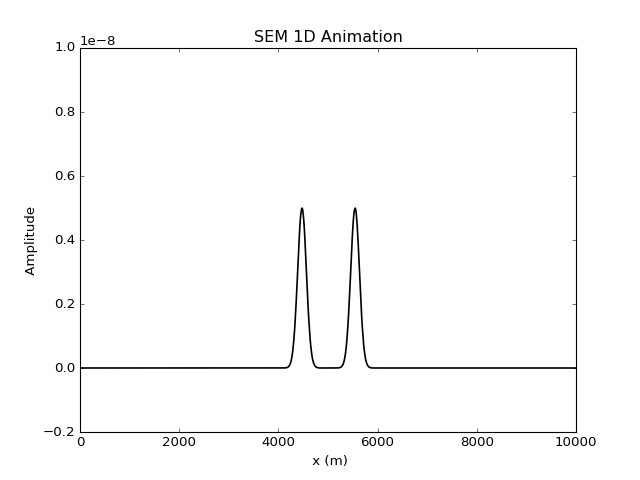

/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:133: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [1]:
"""
Created on Wed Feb  3 20:33:41 2016
"""
#------------------------------------------------------------------------------
#CHAPTER 7:  The Spectral-Element Method 
#------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

from gll import gll
from lagrange1st import lagrange1st 
from ricker import ricker 

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

# Initialization of setup
# ---------------------------------------------------------------
nt = 10000          # number of time steps
xmax = 10000.       # Length of domain
vs = 2500.          # [m/s] S velocity for homogeneneous medium
rho = 2000          # [kg/m3] Density for homogeneous model
mu = rho * vs**2    # Initialization of shear modulus mu
N = 3               # Order of Lagrange polynomials THIS WAS ORIGINALLY 5
ne = 250            # Number of elements
Tdom = .2           # Dominant period of Ricker source wavelet
iplot = 20          # Plotting each iplot snapshot

# variables for elemental matrices
Me = np.zeros(N+1, dtype =  float)
Ke = np.zeros((N+1, N+1), dtype =  float)
# ----------------------------------------------------------------
# Initialization of GLL points integration weights
[xi, w] = gll(N)    # xi -> N+1 coordinates [-1 1] of GLL points
                    # w Integration weights at GLL locations
# Space domain
le = xmax/ne       # Length of elements
# Vector with GLL points  
k=0
xg = np.zeros((N*ne)+1) 
xg[k] = 0
for i in range(1,ne+1):
    for j in range(0,N):
        k = k+1
        xg[k] = (i-1)*le+.5*(xi[j+1]+1)*le

# ---------------------------------------------------------------
dxmin = min(np.diff(xg))  
eps = 0.1           # Courant value
dt = eps*dxmin/vs   # Global time step

# Mapping - Jacobian
J = le/2 
Ji = 1/J             # Inverse Jacobian

# Initialization of 1st derivative of Lagrange polynomials
l1d = lagrange1st(N)   # Array with GLL as columns for each N+1 polynomial

#%% CODE 12: Listing 7.1 Elemental Matrices - Pag 175
# Elemental Mass matrix
for i in range(0, N+1):
    Me[i]=rho*w[i]*J #stored as a vector since it's diagonal

# Elemental Stiffness Matrix
for i in range(0, N+1):
    for j in range(0, N+1):
        for k in range(0, N+1):
            Ke[i,j] = Ke[i,j] + mu*w[k]*Ji**2 *J*l1d[i,k]*l1d[j,k]
 
# ---------------------------------------------------------------                       
# Global Mass matrix
k=-1
ng=(ne-1)*N+N+1
M=np.zeros(2*ng) 

for i in range(1, ne+1):  
    for j in range(0, N+1): 
        k=k+1
        if i>1:
            if j==0:
                k=k-1
        M[k]=M[k]+Me[j]

# Build inverse matrix (this is overkill, but just to get the complete
# matrix system for tutorial purposes)
Minv = np.identity(ng)
for i in range(0,ng):
    Minv[i,i]=1./M[i]
    
# ---------------------------------------------------------------         
# Global Stiffness Matrix
K = np.zeros([ng, ng])
# Values except at element boundaries 
for k in range(1,ne+1):
    i0=(k-1)*N+1
    j0=i0
    for i in range(-1,N):
        for j in range(-1,N):
            K[i0+i,j0+j]=Ke[i+1,j+1]
# Values at element boundaries 
for k in range(2,ne+1):
    i0=(k-1)*N
    j0=i0
    K[i0,j0]=Ke[0,0]+Ke[N,N]
    
# ---------------------------------------------------------------    
# initialize source time function and force vector f
src = ricker(dt,Tdom)
isrc= np.floor(ng/2)   # Source location

# Initialization of solution vectors
u = np.zeros(ng)
uold = u
unew = u
f = u 
  
plt.figure()
plt.ion()
plt.title('SEM 1D Animation')
plt.xlabel(' x (m)')
plt.ylabel(' Amplitude ')

# Initialize animated plot
lines = plt.plot(xg, u, lw=1.5)
plt.show()

#%% CODE 14: Listing 7.3 Extrapolation Scheme - Pag 177
# Time extrapolation
for it in range(nt): 
    # Source initialization
    f= np.zeros(ng)
    if it < len(src):
        f[isrc-1] = src[it-1] 
               
    # Time extrapolation
    unew = dt**2 * np.dot(Minv, f - np.dot(K, u)) + 2 * u - uold
    uold, u = u, unew

    # Animation plot
    if not it % iplot:
        for l in lines:
            l.remove()
            del l
        lines = plt.plot(xg, u, color="black", lw = 1.5)
        plt.draw()
        # time.sleep(0.1)   # to slow the animation down
        # print('it = ', it, ', Max(u) = ', max(u)) 

#********************************************************************************
#CHECK OUT!: Implent directly in the SEM code above 
#********************************************************************************
#%% CODE 13: Listing 7.2 Force vector - Pag 176
# Initialization 
fe = np.zeros((ne, N+1), dtype=float)
s = np.zeros((ne, N+1), dtype=float)
# Point source
s[int(ne/2), 1] = 1
# Force vector
for k in range(ne):
    for i in range(N+1):
        fe[k, i] = s[k, i]*w[i]*J 
#********************************************************************************        
        